# Importing the libraries and Reading the DataFrame

In [1]:
# import the libraries and tools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

# store the data frame in a variable
df = pd.read_csv('C:\\dev\\lung_cancer_analysis\\survey lung cancer.csv')

# Preparing the Data and Pre Proccessing

In [2]:
# convert YES and NO values to numerical binary values 1 and 0 ( feature encoding also known as binary-encoding/label-encoding)
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'YES': 1, 'NO': 0})

# Training the logistic regression model 

------------------------------------------------------------------------------------------------------
Accuracy:     92.04851752021564 %
Recall Score: 97.48667174409749 %
F1-score:     95.59372666168782 %
Cross-validation scores: [0.92113246 0.9231547  0.92922144 0.91809909 0.92307692 0.91902834]
Mean Cross-Validation Score 0.9222854912812871
------------------------------------------------------------------------------------------------------


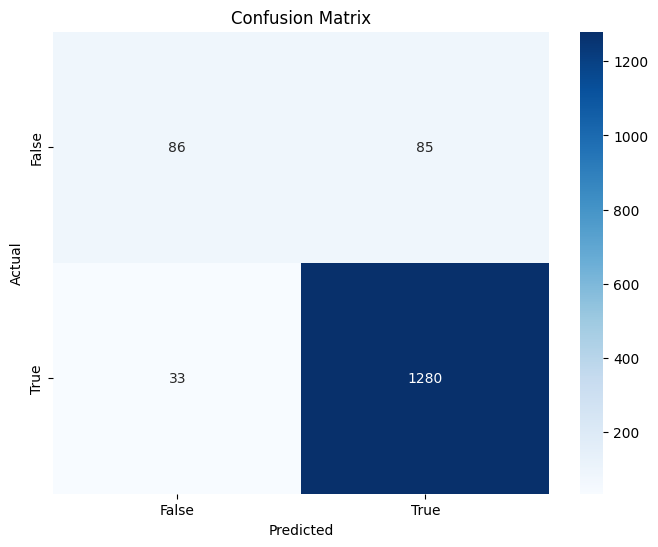

In [3]:
# Define features (X) and target variable (y)
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Create and train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

print('------------------------------------------------------------------------------------------------------')

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:    ", accuracy * 100, "%")

# Calculate the recall score
recall = recall_score(y_test, y_pred)

# Print the recall score
print("Recall Score:", recall * 100, "%")

# Calculate the F1-score
f1 = f1_score(y_test, y_pred)

# Print the F1-score
print("F1-score:    ", f1 * 100, "%")

# Perform 5-fold cross-validation
scores = cross_val_score(model, X_train, y_train, cv=6)

print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score", scores.mean())

print('------------------------------------------------------------------------------------------------------')

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Confusion Matrix analysis

True Positive (TP): 1264 - This means the model correctly predicted 1264 cases of lung cancer where the actual outcome was also lung cancer.

True Negative (TN): 103 - The model correctly predicted 103 cases of no lung cancer where the actual outcome was indeed no lung cancer.

False Positive (FP): 93 - The model incorrectly predicted 93 cases of lung cancer where the actual outcome was no lung cancer (a false alarm).

False Negative (FN): 24 - The model incorrectly predicted 24 cases of no lung cancer where the actual outcome was lung cancer (a missed case).

# Optimizing the model accuracy

------------------------------------------------------------------------------------------------------
Accuracy:     95.4177897574124 %
Recall Score: 0.9846153846153847
F1-score:     0.974124809741248
Cross-validation scores: [0.93191489 0.91396934 0.91822828 0.92078365 0.91822828 0.92078365]
Mean Cross-Validation Score: 0.9206513465511618
------------------------------------------------------------------------------------------------------


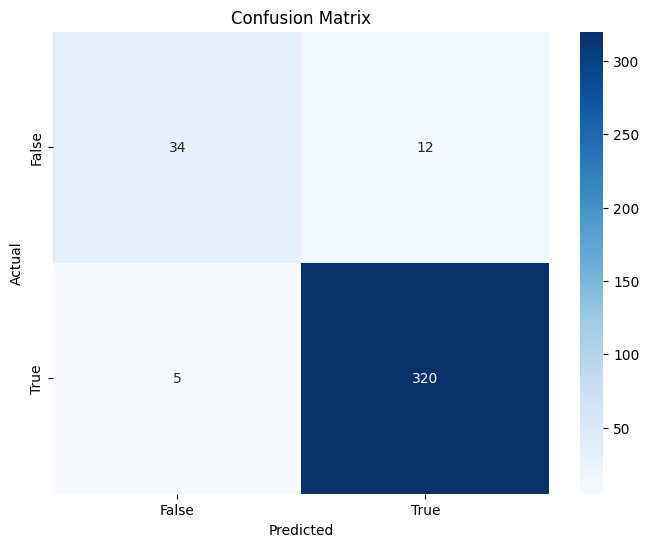

In [ ]:
# removed certain parameters to have smaller feature columns
df = df.drop(['YELLOW_FINGERS', 'SWALLOWING DIFFICULTY', 'SMOKING'], axis=1)

# Retrain the model with the new features
X = df.drop('LUNG_CANCER', axis=1)
y = df['LUNG_CANCER']
 
# changed the test size to only 5% and changed to random state to find the highest accuracy score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=3)

#---------------------------------------------------------------------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('------------------------------------------------------------------------------------------------------')
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:    ", accuracy * 100, "%")
recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)
f1 = f1_score(y_test, y_pred)
print("F1-score:    ", f1)
scores = cross_val_score(model, X_train, y_train, cv=6)
print("Cross-validation scores:", scores)
print("Mean Cross-Validation Score:", scores.mean())
print('------------------------------------------------------------------------------------------------------')
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()